In [1]:
import pandas as pd
import glob
import os
import numpy as np
from tqdm import tqdm
import re

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')


false          7408
partly true    6451
true           1696
Name: labelCode, dtype: int64


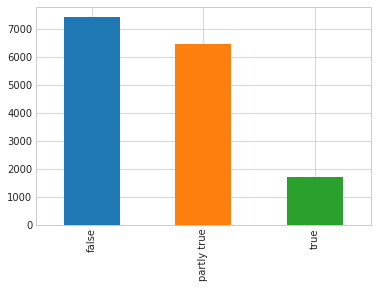

,claim,claimant,date,id,label,related_articles,labelCode
15550,"The omnibus spending bill has ""9,427 pork barr...",John McCain,2009-02-25,17137,2,"[82947, 93503]",true
15551,Representative Maxine Waters said Muslims were...,,2017-06-06,17138,0,"[103780, 104726, 126025]",false
15552,"""We were not, I repeat, were not told that wat...",Nancy Pelosi,2009-04-23,17139,0,"[11331, 68915, 2186, 2185, 88418, 81950]",false
15553,"As of August 2017, members of the public could...",,2018-05-14,17140,2,"[121353, 152864, 154411]",true
15554,"""We don't get any of that information"" from th...",Scott Walker,2016-12-23,17141,1,"[69545, 88929, 14698]",partly true


In [2]:
train = pd.read_json ('data/train.json')
labels = {0:'false', 1:'partly true', 2:'true'}

def label(x):
    return labels[x]

train['labelCode'] = train.label.apply(label)


print(train.labelCode.value_counts())

train.labelCode.value_counts().plot(kind='bar')

plt.show()
train.tail()


In [3]:
# print(glob.glob("data/train_articles/*.txt")[:100])
files = [f for f in glob.glob("data/train_articles/*.txt", recursive=True)]
# print(files[:10])


articles = []
for file in files:
    with open(file) as myfile:
        data = "".join(line.rstrip() for line in myfile)
        articles.append({'id' : os.path.basename(file)[:-4], 'text' : data})

articles_df = pd.DataFrame.from_dict(articles)
articles_df.reset_index(drop=True, inplace=True)
# articles_df.set_index('id', inplace=True)

articles_df.id = articles_df.id.astype(int)
articles_df.text = articles_df.text.apply(str)
# print(articles_df[articles_df.id == 112386]['text'])
# print(articles_df.describe())

articles_df.tail()

,id,text
64969,79940,"Rubio: Legalization first, border security whe..."
64970,81412,"Amid Health Law Expansion, Some States Trim Me..."
64971,112386,Library of CongressSenate Committee Any Commit...
64972,78733,Fort BraggFort Bragg is located just west of F...
64973,93980,Obama's Russia Reset a 'Disaster'articleChess ...


In [4]:
# print(train_df.iloc[0]['related_articles'][0])

train_complete = []
for index, row in tqdm(train.iterrows()):
    for article in row['related_articles']:
        train_complete.append(
            {
                'claim' : row['claim'],
                'claimant' : row['claimant'],
                'article' : articles_df.loc[articles_df['id'] == article].iloc[0]['text'],
                'date' : row['date'],
                'label' : row['label']
            }
        )
#     break

train_df = pd.DataFrame(train_complete)
# print(train.loc[1])
train_df.to_csv('data/full_train.cvs')
train_df.tail()

15555it [00:42, 363.79it/s]


,article,claim,claimant,date,label
77675,"Charvat v. Resort Marketing Group, Inc. et al....","As of August 2017, members of the public could...",,2018-05-14,2
77676,Update on Class-Action Lawsuit Over Cruise Com...,"As of August 2017, members of the public could...",,2018-05-14,2
77677,Gov. Scott Walker Previews Next Year In State ...,"""We don't get any of that information"" from th...",Scott Walker,2016-12-23,1
77678,Wrong: Donald Trump says there's 'no system to...,"""We don't get any of that information"" from th...",Scott Walker,2016-12-23,1
77679,David A. MartinA leading scholar in immigratio...,"""We don't get any of that information"" from th...",Scott Walker,2016-12-23,1


Average word length of article in train is 1117.
Average claim length 22.99884281581485


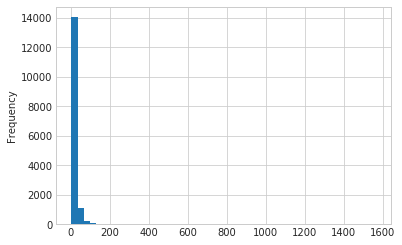

Average article length 1117.2562563486933


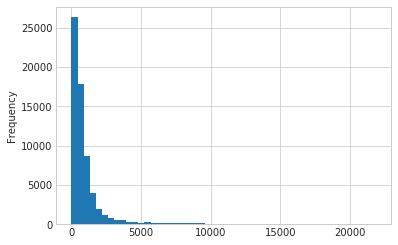

In [5]:
# print('Average word length of claim in train is {0:.0f}.'.format(np.mean(train['claim'].apply(lambda x: len(x.split())))))
print('Average word length of article in train is {0:.0f}.'.format(np.mean(articles_df['text'].apply(lambda x: len(x.split())))))

train['length'] = train['claim'].apply(lambda x: len(x.split()))
articles_df['length'] = articles_df['text'].apply(lambda x: len(x.split()))
print('Average claim length', train.length.mean())
train['length'].plot(bins=50, kind='hist')
plt.show()
print('Average article length', articles_df.length.mean())
articles_df['length'].plot(bins=50, kind='hist')

In [6]:
from keras.preprocessing.text import Tokenizer

max_features = 120000
tk = Tokenizer(lower = True, filters='', num_words=max_features)
tk.fit_on_texts(train['article'].values + train['claim'].values)


Using TensorFlow backend.


KeyError: 'article'

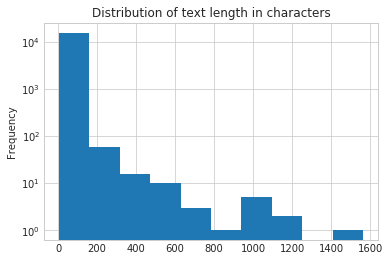

In [7]:
train['claim'].apply(lambda x: len(x.split())).plot(kind='hist', bins=10)
plt.yscale('log')
plt.title('Distribution of text length in characters')
plt.show()

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D 
from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping


from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
import os, re, csv, math, codecs

sns.set_style("whitegrid")
np.random.seed(0)

DATA_PATH = '../input/'
EMBEDDING_DIR = '../input/'

MAX_NB_WORDS = 100000
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])

from subprocess import check_output
# print(check_output(["ls", "../input"]).decode("utf8"))

In [9]:
#load embeddings
print('loading word embeddings...')
embeddings_index = {}
f = codecs.open('/home/sonic/.keras/datasets/wiki-news-300d-1M.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

3111it [00:00, 15546.36it/s]

loading word embeddings...


999995it [01:10, 14172.18it/s]

found 999995 word vectors


In [11]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

X = train_df[['claim', 'claimant']]
y = train_df['label']

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)
# convert integers to dummy variables (i.e. one hot encoded)
y = np_utils.to_categorical(y)

print(X.tail())
# print(y.tail())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

print("num train: ", X_train.shape)
print("num test: ", y_train.shape)



                                                   claim      claimant
77675  As of August 2017, members of the public could...              
77676  As of August 2017, members of the public could...              
77677  "We don't get any of that information" from th...  Scott Walker
77678  "We don't get any of that information" from th...  Scott Walker
77679  "We don't get any of that information" from th...  Scott Walker
num train:  (52045, 2)
num test:  (52045, 3)


In [12]:
label_names = ["true", "almost", "false"]
# y_train = train_df[label_names].values

# #visualize word distribution
# train_df['doc_len'] = train_df['comment_text'].apply(lambda words: len(words.split(" ")))
# max_seq_len = np.round(train_df['doc_len'].mean() + train_df['doc_len'].std()).astype(int)
# sns.distplot(train_df['doc_len'], hist=True, kde=True, color='b', label='doc len')
# plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
# plt.title('comment length'); plt.legend()
# plt.show()

In [13]:
y_train.head()

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [14]:
raw_docs_train = X_train['claim'].tolist()
raw_docs_test = X_test['claim'].tolist() 
num_classes = len(label_names)

X_train['doc_len'] =  X_train['claim'].apply(len)
X_test['doc_len'] =  X_test['claim'].apply(len)

max_seq_len = np.round(X_train['doc_len'].mean() + X_train['doc_len'].std()).astype(int)

print("pre-processing train data...")
processed_docs_train = []
for doc in tqdm(raw_docs_train):
    tokens = tokenizer.tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_train.append(" ".join(filtered))
#end for

processed_docs_test = []
for doc in tqdm(raw_docs_test):
    tokens = tokenizer.tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_test.append(" ".join(filtered))
#end for

print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs_train + processed_docs_test)  #leaky
word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

#pad sequences
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
 46%|████▌     | 23681/52045 [00:00<00:00, 118399.75it/s]

pre-processing train data...


100%|██████████| 25635/25635 [00:00<00:00, 118668.33it/s]


tokenizing input data...
dictionary size:  21539


In [15]:
#training params
batch_size = 256 
num_epochs = 8 

#model parameters
num_filters = 64 
embed_dim = 300 
weight_decay = 1e-4


In [16]:
#embedding matrix
print('preparing embedding matrix...')
words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 2695


In [17]:
print("sample words not found: ", np.random.choice(words_not_found, 10))

sample words not found:  ['douma' 'satmattweet' 'brazile' 'scottgustin' 'arcot' 'defazio'
 'dimassimo' 'kamkwamba' 'ciggerets' 'bakken']


In [29]:
import keras
from keras_self_attention import SeqSelfAttention


model = keras.models.Sequential()
# model.add(keras.layers.Embedding(input_dim=10000,
#                                  output_dim=300,
#                                  mask_zero=True))

model.add(Embedding(nb_words, embed_dim,# mask_zero=True,
          weights=[embedding_matrix], input_length=max_seq_len, trainable=False))

model.add(keras.layers.Bidirectional(keras.layers.GRU(units=128,
                                                       return_sequences=True)))

model.add(SeqSelfAttention(attention_activation='sigmoid'))

model.add(Flatten())
model.add(keras.layers.Dense(units=num_classes))
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy'],
)
model.summary(line_length=100)

#model training
hist = model.fit(word_seq_train[:1000], y_train[:1000], batch_size=batch_size, 
                 epochs=num_epochs, validation_split=0.1, shuffle=True, verbose=1)

____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
embedding_11 (Embedding)                     (None, 381, 300)                        6461700        
____________________________________________________________________________________________________
bidirectional_11 (Bidirectional)             (None, 381, 256)                        329472         
____________________________________________________________________________________________________
seq_self_attention_11 (SeqSelfAttention)     (None, 381, 256)                        16449          
____________________________________________________________________________________________________
flatten_4 (Flatten)                          (None, 97536)                           0              
___________________________________________________________________________________________

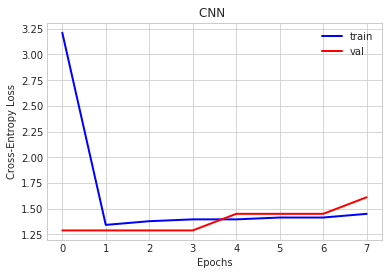

KeyError: 'acc'

<Figure size 432x288 with 0 Axes>

In [31]:
plot_history(hist)

In [ ]:
#CNN architecture
print("training CNN ...")
model = Sequential()
model.add(Embedding(nb_words, embed_dim,
          weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(num_classes, activation='sigmoid'))  #multi-label (k-hot encoding)

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

In [ ]:
#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

In [ ]:
#model training
hist = model.fit(word_seq_train, y_train, batch_size=batch_size, 
                 epochs=num_epochs, callbacks=callbacks_list,
                 validation_split=0.1, shuffle=True, verbose=1)

In [30]:
def plot_history(hist):
    #generate plots
    plt.figure()
    plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
    plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
    plt.title('CNN ')
    plt.xlabel('Epochs')
    plt.ylabel('Cross-Entropy Loss')
    plt.legend(loc='upper right')
    plt.show()

    plt.figure()
    plt.plot(hist.history['acc'], lw=2.0, color='b', label='train')
    plt.plot(hist.history['val_acc'], lw=2.0, color='r', label='val')
    plt.title('CNN ')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    plt.show()

# plot_history(hist)

In [ ]:
from keras.layers import GlobalAveragePooling1D
# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model = Sequential()
model.add(Embedding(nb_words, embed_dim,
          weights=[embedding_matrix], input_length=max_seq_len, trainable=False))

# we add a GlobalAveragePooling1D, which will average the embeddings
# of all words in the document
model.add(GlobalAveragePooling1D())

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(3, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

hist = model.fit(word_seq_train, y_train,
          batch_size=batch_size, validation_split=0.1, 
          epochs=num_epochs)

plot_history(hist)

In [32]:
y_test = model.predict(word_seq_test)


InvalidArgumentError: indices[8,376] = 21539 is not in [0, 21539)
	 [[{{node embedding_11/embedding_lookup}}]]

In [ ]:
# Results
print('sklearn Macro-F1-Score:', f1_score(y_true, y_pred, average='macro'))

In [ ]:
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding

# define documents
X = train_df['claim']
y = train_df['label']

# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(X)
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = np.asanyarray(t.texts_to_sequences(X))
print(encoded_docs)

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)
# convert integers to dummy variables (i.e. one hot encoded)
y = np_utils.to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(encoded_docs, y, test_size=0.33, random_state=42)

print("num train: ", X_train.shape)
print("num test: ", X_test.shape)

# print(encoded_docs)
# pad documents to a max length of 4 words
max_length = 200
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test = pad_sequences(y_test, maxlen=max_length, padding='post')

# print(X_train[1])
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

In [ ]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('/home/sonic/.keras/datasets/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 100))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


In [ ]:
# define model
model = Sequential()
e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length, trainable=False)
model.add(e)
# model.add(Flatten())

# we add a GlobalAveragePooling1D, which will average the embeddings
# of all words in the document
model.add(GlobalAveragePooling1D())

model.add(Dense(3, activation='softmax'))
# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
# summarize the model
print(model.summary())
# fit the model
hist = model.fit(X_train, y_train, epochs=10, verbose=1)
# plot_history(hist)

# evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=2)
print('Accuracy: %f' % (accuracy*100))

In [ ]:
y_pred = model.predict(X_test)
print(y_pred.shape, y_pred[:10])

print(np.unique(y_pred))


def decode(data):
    decoded = []
    for i in range(data.shape[0]):
        print('sssss', data[i], np.argmax(data[i]))
        decoded.append(np.argmax(data[i]))
        break
    
    return np.asanyarray(decoded)

print(decode(y_pred)[:10])
print()

y_pred = decode(y_pred)
y_true = decode(y_test)

print(np.unique(y_pred))
print(np.unique(y_true))
print(y_pred)
print(y_pred.shape)
print(y_test.shape)
from sklearn.metrics import f1_score, classification_report

# Results
print('sklearn Macro-F1-Score:', f1_score(y_true, y_pred, average='macro'))
print('sklearn Micro-F1-Score:', f1_score(y_true, y_pred, average='micro'))  
print('sklearn weighted-F1-Score:', f1_score(y_true, y_pred, average='weighted'))  
print('sklearn no average-F1-Score:', f1_score(y_true, y_pred, average=None))

print(classification_report(y_true, y_pred))

In [ ]:
from __future__ import print_function
import numpy as np

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import GlobalAveragePooling1D
from keras.datasets import imdb


def create_ngram_set(input_list, ngram_value=2):
    """
    Extract a set of n-grams from a list of integers.
    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=2)
    {(4, 9), (4, 1), (1, 4), (9, 4)}
    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=3)
    [(1, 4, 9), (4, 9, 4), (9, 4, 1), (4, 1, 4)]
    """
    return set(zip(*[input_list[i:] for i in range(ngram_value)]))


def add_ngram(sequences, token_indice, ngram_range=2):
    """
    Augment the input list of list (sequences) by appending n-grams values.
    Example: adding bi-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017}
    >>> add_ngram(sequences, token_indice, ngram_range=2)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42]]
    Example: adding tri-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017, (7, 9, 2): 2018}
    >>> add_ngram(sequences, token_indice, ngram_range=3)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42, 2018]]
    """
    new_sequences = []
    for input_list in sequences:
        new_list = input_list[:]
        for ngram_value in range(2, ngram_range + 1):
            for i in range(len(new_list) - ngram_value + 1):
                ngram = tuple(new_list[i:i + ngram_value])
                if ngram in token_indice:
                    np.append( new_list, token_indice[ngram])
        new_sequences.append(new_list)

    return np.asanyarray(new_sequences)

# Set parameters:
ngram_range = 2 #will add bi-grams features
# ngram_range = 1
max_features = 20000
maxlen = 200
batch_size = 32
embedding_dims = 100
epochs = 5

print('Loading data...')
# (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')
print('Average train sequence length: {}'.format(np.mean(list(map(len, X_train)), dtype=int)))
print('Average test sequence length:  {}'.format(np.mean(list(map(len, X_test)), dtype=int)))

if ngram_range > 1:
    print('Adding {}-gram features'.format(ngram_range))
    # Create set of unique n-gram from the training set.
    ngram_set = set()
    for input_list in X_train:
        for i in range(2, ngram_range + 1):
            set_of_ngram = create_ngram_set(input_list, ngram_value=i)
            ngram_set.update(set_of_ngram)

    # Dictionary mapping n-gram token to a unique integer.
    # Integer values are greater than max_features in order
    # to avoid collision with existing features.
    start_index = max_features + 1
    token_indice = {v: k + start_index for k, v in enumerate(ngram_set)}
    indice_token = {token_indice[k]: k for k in token_indice}

    # max_features is the highest integer that could be found in the dataset.
    max_features = np.max(list(indice_token.keys())) + 1

    # Augmenting x_train and x_test with n-grams features
    X_train = add_ngram(X_train, token_indice, ngram_range)
    X_test = add_ngram(X_test, token_indice, ngram_range)
    print('Average train sequence length: {}'.format(np.mean(list(map(len, X_train)), dtype=int)))
    print('Average test sequence length: {}'.format(np.mean(list(map(len, X_test)), dtype=int)))

print('Pad sequences (samples x time)')
# x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
# x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', X_train.shape)
print('x_test shape:', X_test.shape)

print('Build model...')
model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(max_features ,
                    embedding_dims,
                    input_length=maxlen))

# we add a GlobalAveragePooling1D, which will average the embeddings
# of all words in the document
model.add(GlobalAveragePooling1D())

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(3, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, y_test))

In [ ]:

# evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=2)
print('Accuracy: %f' % (accuracy*100))